# 20 - Plug-and-Play Estimators
 
So far, we've seen how to debias our data in the case where the treatment is not randomly assigned, which results in confounding bias. That helps us with the identification problem in causal inference. In other words, once the units are exchangeable, or $ Y(0), Y(1) \perp X$, it becomes possible to learn the treatment effect. But we are far from done. 
 
Identification means that we can find the average treatment effect. In other words, we know how effective a treatment is on average. Of course this is useful, as it helps us to decide if we should roll out a treatment or not. But we want more than that. We want to know if there are subgroups of units that respond better or worse to the treatment. That should allow for a much better policy, one where we only treat the ones that will benefit from it.
 
 
## Problem Setup
 
Let's recall our setup of interest. Given the potential outcomes, we can define the individual treatment effect as the difference between the potential outcomes.
 
$
\tau_i = Y_i(1) − Y_i(0),
$
 
or, the continuous treatment case, $\tau_i = \partial Y(t)$, where $t$ is the treatment variable. Of course, we can never observe the individual treatment effect, because we only get to see the one of potential outcomes
 
$
Y^{obs}_i(t)= 
\begin{cases}
Y_i(1), & \text{if } t=1\\
Y_i(0), & \text{if } t=0
\end{cases}
$
 
We can define the average treatment effect (ATE) as
 
$
\tau = E[Y_i(1) − Y_i(0)] = E[\tau_i]
$
 
and the conditional average treatment effect (CATE) as
 
$
\tau(x) = E[Y_i(1) − Y_i(0)|X] = E[\tau_i|X]
$
 
In Part I of this book, we've focused mostly on the ATE. Now, we are interested in the CATE. The CATE is useful for personalising a decision making process. For example, if you have a drug as the treatment $t$, you want to know which type of patients are more responsive to the drug (higher CATE) and if there are some types of patient with a negative response (CATE < 0). 
 
We've seen how to estimate the CATE using a linear regression with interactions between the treatment and the features
 
$
y_i = \beta_0 + \beta_1 t_i + \beta_2 X_i + \beta_3 t_i X_i + e_i.
$
 
If we estimate this model, we can get estimates for $\tau(x)$
 
$
\hat{\tau}(x) = \hat{\beta}_1 + \hat{\beta}_3 X_i
$
 
Still, the linear models have some drawbacks. The main one being the linearity assumption on $X$. Notice that you don't even care about $\beta_2$ on this model. But if the features $X$ don't have a linear relationship with the outcome, your estimates of the causal parameters $\beta_1$ and $\beta_3$ will be off. 
 
It would be great if we could replace the linear model by a more flexible machine learning model. We could even plug the treatment as a feature to a ML model, like boosted trees or a neural network
 
$
y_i = M(X_i, T_i) + e_i
$
 
but from there, it is not clear how we can get treatment effect estimates, since this model will output $\hat{y}$ predictions, not $\hat{\tau(x)}$ predictions. Ideally, we would use a machine learning regression model that, instead of minimising the outcome MSE
 
$
E[(Y_i - \hat{Y}_i)^2]
$
 
would minimise the treatment effect MSE
 
$
E[(\tau(x)_i - \hat{\tau}(x)_i)^2] = E[(Y_i(1) - Y_i(0) - \hat{\tau}(x)_i)^2].
$
 
However, this criterion is what we call infeasible. Again, the problem here is that $\tau(x)_i$ is not observable, so we can't optimize it directly. This puts us in a tough spot... Let's try to simplify it a bit and maybe we can think of something.

![img](./data/img/plug-and-play-estimators/infeasible.png)

## Target Transformation
 
Suppose your treatment is binary. Let's say you are an investment firm testing the effectiveness of sending a financial education email. You hope the email will make people invest more. Also, let's say you did a randomized study where 50% of the customers got the email and the other 50% didn't. 
 
Here is a crazy idea: let's transform the outcome variable by multiplying it with the treatment.
 
$
Y^*_i = 2 Y_i * T_i - 2 Y_i*(1-T_i)
$
 
 
So, if the unit was treated, you would take the outcome and multiply it by 2. If it wasn't treated, you would take the outcome and multiply it by -2. For example, if one of your customers invested BRL 2000,00 and got the email, the transformed target would be 4000. However, if he or she didn't get the email, it would be -4000. 
 
This seems very odd, because you are saying that the effect of the email can be a negative number, but bear with me. If we do a little bit of math, we can see that, on average or in expectation, this transformed target will be the treatment effect. This is nothing short of amazing. What I'm saying is that by applying this somewhat wacky transformation, I get to estimate something that I can't even observe. 
 
To understand that, we need a bit of math. Because of random assignment, we have that $T \perp Y(0), Y(1)$, which is our old unconfoundedness friend. That implies that $E[T, Y(t)]=E[T]*E[Y(t)]$, which is the definition of independence.


Also, we know that

$
Y_i*T_i = Y(1)_i*T_i \text{ and }  Y_i*(1-T_i) = Y(0)_i*T_i
$

because the treatment is what materializes one or the other potential outcomes. With that in mind, let's take the expected value of $Y^*_i$ and see what we end up with. 
 
$
\begin{align}
E[Y^*_i|X_i=x] &= E[2 Y(1)_i * T_i - 2 Y(0)_i*(1-T_i)|X_i=x] \\
&= 2E[Y(1)_i * T_i | X_i=x] - 2E[Y(0)_i*(1-T_i)|X_i=x]\\
&= 2E[Y(1)_i| X_i=x] * E[ T_i | X_i=x] - 2E[Y(0)_i| X_i=x]*E[(1-T_i)|X_i=x] \\
&= 2E[Y(1)_i| X_i=x] * 0.5 - 2E[Y(0)_i| X_i=x]*0.5 \\ 
&= E[Y(1)_i| X_i=x] - E[Y(0)_i| X_i=x] \\
&= \tau(x)_i
\end{align}
$
 
So, this apparently crazy idea ended up being an unbiased estimate of the individual treatment effect $\tau(x)_i$. Now, we can replace our infeasible optimization criterion with 
 
$
E[(Y^*_i - \hat{\tau}(x)_i)^2]
$
 
In simpler terms, all we have to do is use any regression machine learning model to predict $Y^*_i$ and this model will output treatment effect predictions. 
 
Now that we've solved the simple case, what about the more complicated case, where treatment is not 50% 50%, or not even randomly assigned? As it turns out, the answer is a bit more complicated, but not much. First, if we don't have random assignment, we need at least conditional independence $T \perp Y(1), Y(0) | X$. That is, controlling for $X$, $T$ is as good as random. With that, we can generalize the transformed target to
 
$
Y^*_i = Y_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}
$
 
where $e(X_i)$ is the propensity score. So, if the treatment is not 50% 50%, but randomized with a different probability $p$, all you have to do is replace the propensity score in the above formula with $p$. If the treatment is not random, then you have to use the propensity score, either stored or estimated. 
 
If you take the expectation of this, you will see that it also matches the treatment effect. The proof is left as an exercise to the reader. Just kidding, here it is. It's a bit cumbersome, so feel free to skip it.  
 
$
\begin{align}
E[Y^*_i|X_i=x] &= E\big[Y_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}|X_i=x\big] \\
&= E\big[Y_i T_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))} + Y_i (1-T_i) * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}|X_i=x\big]\\
&= E\big[Y(1)_i * \dfrac{T_i(1 - e(X_i))}{e(X_i)(1-e(X_i))} | X_i=x\big] - E\big[Y(0)_i * \dfrac{(1-T_i)e(X_i)}{e(X_i)(1-e(X_i))}|X_i=x\big]\\
&= \dfrac{1}{e(X_i)} E[Y(1)_i * T_i|X_i=x] - \dfrac{1}{1-e(X_i)} E[Y(0)_i * (1-T_i)| X_i=x]\\
&= \dfrac{1}{e(X_i)} E[Y(1)_i|X_i=x] * E[T_i|X_i=x] - \dfrac{1}{1-e(X_i)} E[Y(0)_i|X_i=x] * E[(1-T_i)| X_i=x]\\
&= E[Y(1)_i|X_i=x] - E[Y(0)_i|X_i=x]\\
&= \tau(x)_i
\end{align}
$
 
As always, I think this will become much more concrete with an example. Again, consider the investment emails we've sent trying to make people invest more. The outcome variable the binary (invested vs didn't invest) `converted`.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast

In [2]:
email = pd.read_csv("./data/invest_email_rnd.csv")
email.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,1,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,1,0,1,1
3,39.7,2326.37,15657.97,6345.20,1,1,1,0
4,35.3,2787.26,27074.44,14114.86,1,1,1,0


Our goal here is one of personalization. Let's focus on email-1. We wish to send it only to those customers who will respond better to it. In other words, we wish to estimate the conditional average treatment effect of email-1
 
$
E[Converted(1)_i - Converted(0)_i|X_i=x] = \tau(x)_i
$
 
so that we can target those customers who will have the best response to the email (higher CATE)
 
But first, let's break our dataset into a training and a validation set. We will estimate $\tau(x)_i$ on one set and evaluate the estimates on the other.

In [3]:
from sklearn.model_selection import train_test_split

np.random.seed(123)
train, test = train_test_split(email, test_size=0.4)
print(train.shape, test.shape)

(9000, 8) (6000, 8)


Now, we will apply the target transformation we've just learned. Since the emails were randomly assigned (although not on a 50% 50% basis), we don't need to worry about the propensity score. Rather, it is constant and equal to the treatment probability.

In [4]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

ps = train[T].mean()

y_star_train = train[y] * (train[T] - ps)/(ps*(1-ps))

With the transformed target, we can pick any ML regression algorithm to predict it. Lets use boosted trees here.

In [5]:
from lightgbm import LGBMRegressor

np.random.seed(123)
cate_learner = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)
cate_learner.fit(train[X], y_star_train);

This model can now estimate $\tau(x)_i$. In other words, what it outputs is $\hat{\tau}(x)_i$. For example, if we make predictions on the test set, we will see that some units have higher CATE than others. For example, customer 6958 has a CATE of 0.1, meaning the probability he or she will buy our investment product is predicted to increase by 0.1 if we send the email to this customer. In contrast, for customer 3903, the probability of buying the product is predicted to increase just 0.04.

In [6]:
test_pred = test.assign(cate=cate_learner.predict(test[X]))
test_pred.head()

,age,income,insurance,invested,em1,em2,em3,converted,cate
6958,40.9,4486.14,37320.33,12559.25,0,0,1,0,0.105665
7534,42.6,6386.19,13270.47,29114.42,0,0,1,0,0.121922
2975,47.6,1900.26,25588.72,2420.39,0,0,1,0,0.034161
3903,41.0,5802.19,57087.37,20182.20,1,0,1,1,0.046805
8437,49.1,2202.96,5050.81,9245.88,1,0,1,0,-0.009099


To evaluate how good this model is, we can show the cumulative gain curves, for both training and testing sets. 

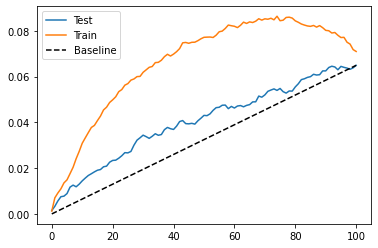

In [7]:
gain_curve_test = cumulative_gain(test_pred, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=cate_learner.predict(train[X])), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend();

As we can see, this plug and play estimator is better than random on the test set. Still, it looks like it is overfitting a lot, since the performance on the training set is much better than that of the test set. 
 
That is actually one of the biggest downsides of this target transformation technique. With this target transformation, you do get a lot of simplicity, since you can just transform the target and use any ML estimator to predict heterogeneous treatment effects. The cost of it is that you get a lot of variance. That's because the transformed target is a very noisy estimate of the individual treatment effect and that variance gets transferred to your estimation. This is a huge problem if you don't have a lot of data, but it should be less of a problem in big data applications, where you are dealing with more than 1MM samples.

## The Continuous Treatment Case

![img](./data/img/plug-and-play-estimators/second-estimator.png)

Another obvious downside of the target transformation method is that it only works for discrete or binary treatments. This is something you see a lot in the causal inference literature. Most of the research is done for the binary treatment case, but you don't find a lot about continuous treatments. That bothered me a lot, because in the industry, continuous treatments are everywhere, mostly in the form of prices you need to optimize. So, even though I couldn't find anything regarding target transformations for continuous treatment, I came up with something that works in practice. Just keep in mind that I don't have a super solid econometric research around it.
 
To motivate it, let's go back to the ice cream sales example. There, we were tasked with the problem of estimating demand elasticity to price so that we can better set the ice cream prices to optimize our revenues. Recall that the event sample in the dataset is a day and we wish to know when people are less sensitive to price increases. Also, recall that prices are randomly assigned in this dataset, which means we don't need to worry about confounding bias.

In [8]:
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv")
prices_rnd.head()

,temp,weekday,cost,price,sales
0,25.8,1,0.3,7,230
1,22.7,3,0.5,4,190
2,33.7,7,1.0,5,237
3,23.0,4,0.5,5,193
4,24.4,1,1.0,3,252


As before, let's start by separating our data into training and a testing set.

In [9]:
np.random.seed(123)
train, test = train_test_split(prices_rnd, test_size=0.3)
train.shape, test.shape

((3500, 5), (1500, 5))


Now is where we need a little bit of creativity. For the discrete case, the conditional average treatment effect is given by how much the outcome changes when we go from untreated to treated, conditioned on unit characteristics $X$. 
 
$
\tau(x) = E[Y_i(1) − Y_i(0)|X] = E[\tau_i|X]
$
 
In plain english, this is estimating the impact of the treatment on different unit profiles, where profiles are defined using the features $X$. For the continuous case, we don't have that on-off switch. Units are not treated or untreated. Rather, they are all treated, but with different intensities. Therefore, we can't talk about the effect of giving the treatment. Rather, we need to speak in terms of increasing the treatment. In other words, we wish to know how the outcome would change if we increase the treatment by some amount. This is like estimating the partial derivative of the outcome function $Y$ on the treatment $t$. And because we wish to know that for each group (the CATE, not the ATE), we condition on the features $X$
 
$
\tau(x) = E[\partial Y_i(t)|X] = E[\tau_i|X]
$
 
How can we estimate that? First, let's consider the easy case, where the outcome is linear on the treatment. Suppose you have two types of days: hot days (yellow) and cold days (blue). On cold days people are more sensitive to price increases. Also, as price increases, demand falls linearly.
 
![img](./data/img/plug-and-play-estimators/linear-case.png)
 
In this case, the CATE will be the slope of each demand line. These slopes will tell us how much demand will fall if we increase price by any amount. If this relationship is indeed linear, we can estimate those elasticities with the coefficient of a simple linear regression estimate on hot days and on cold days separately. 
 
$$
\hat{\tau(x)} = Cov(Y_i, T_i)/Var(T_i) = \dfrac{\sum(Y_i- \bar{Y})(T_i - \bar{T})}{\sum (T_i - \bar{T})^2}
$$
 
We can be inspired by this estimator and think about what it would be like for an individual unit. In other words, what if we have that same thing up there, defined for each day. In my head, it would be something like this:

$
Y^*_i = (Y_i- \bar{Y})\dfrac{(T_i - \bar{T})}{\sigma^2_T}
$
 
In plain English, we would transform the original target by subtracting the mean from it, then we would multiply it by the treatment, from which we've also subtracted the mean from. Finally, we would divide it by the treatment variance. Alas, we have a target transformation for the continuous case. 

![img](./data/img/plug-and-play-estimators/genious.jpeg)

The question now is: does it work? As a matter of fact it does and we can go over a similar proof for why it works, just like we did in the binary case. First, lets call
 
$
V_i = \dfrac{(T_i - \bar{T})}{\sigma^2_T}
$
 
notice that $E[V_i|X_i=x]=0$ because under random assignment $E[T_i|X_i=x]=\bar{T}$. In other words, for every region of X, $E[T_i]=\bar{T}$. Also $E[T_i V_i | X_i=x]=1$ because $E[T_i(T_i - \bar{T})|X_i=x] = E[(T_i - \bar{T})^2|X_i=x]$, which is the treatment variance. Finally, under conditional independence (which we get for free in the random treatment assignment case), $E[T_i e_i | X_i=x] = E[T_i | X_i=x] E[e_i | X_i=x]$.
 
To show that this target transformation works, we need to remember that we are estimating the parameter for a local linear model
 
$
Y_i = \alpha + \beta T_i + e_i | X_i=x
$
 
In our example, those would be the linear models for the hot and cold days. Here, we are interested in the $\beta$ parameter, which is our conditional elasticity or CATE. With all that, we can prove that
 
$
\begin{align}
E[Y^*_i|X_i=X] &= E[(Y_i-\bar{Y})V_i | X_i=x] \\
&= E[(\alpha + \beta T_i + e_i - \bar{Y})V_i | X_i=x] \\
&= \alpha E[V_i | X_i=x] + \beta E[T_i V_i | X_i=x] + E[e_i V_i | X_i=x] \\
&= \beta + E[e_i V_i | X_i=x] \\
&= \beta = \tau(x)
\end{align}
$
 
Bare in mind that this only works when the treatment is randomized. For non randomized treatment, we have to replace $\bar{T}$ by $M(X_i)$, where $M$ is a model that estimates $E[T_i|X_i=x]$. 
 
$
Y^*_i = (Y_i- \bar{Y})\dfrac{(T_i - M(T_i))}{(T_i - M(T_i))^2}
$
 
This will make sure that the term $\alpha E[V_i | X_i=x]$ in the third line vanishes to zero and that the term $E[T_i V_i | X_i=x]$ goes to 1. Notice that you don't actually need $E[T_i V_i | X_i=x]$ to go to 1 if you just want to order units in terms of treatment effect. In other words, if you just want to know in which days demand is more sensitive to price increases but you don't need to know by how much, it doesn't matter if the $\beta$ estimates are scaled up or down. If that is the case, you can omit the denominator.
 
$
Y^*_i = (Y_i- \bar{Y})(T_i - M(T_i))
$
 
If all that math seems tiresome, don't worry. The code is actually very simple. Once again, we transform our training target with the formulas seen above. Here, we have random treatment assignments, so we don't need to build a model that predicts prices. I'm also omitting the denominator, because here I only care about ordering the treatment effect.

In [10]:
y_star_cont = (train["price"] - train["price"].mean()) * (train["sales"] - train["sales"].mean())

Then, just like before, we fit a regression ML model to predict that target. 


In [11]:
cate_learner = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)

np.random.seed(123)
cate_learner.fit(train[["temp", "weekday", "cost"]], y_star_cont)

cate_test_transf_y = cate_learner.predict(test[["temp", "weekday", "cost"]])

test_pred = test.assign(cate=cate_test_transf_y)
test_pred.sample(5)

,temp,weekday,cost,price,sales,cate
2815,15.7,4,1.5,3,187,-3.536723
257,29.4,3,1.0,3,209,8.334653
2585,24.6,6,1.0,10,197,5.628261
3260,20.2,1,0.5,4,246,-45.753226
1999,10.0,4,0.5,10,139,-7.794578


This time, the CATE's interpretation is non intuitive. Since we've removed the denominator from the target transformation, this CATE we are seeing is scaled by $Var(X)$. However, this prediction should still order the treatment effect pretty well. To see that, we can use the cumulative gain curve, just like we did before.

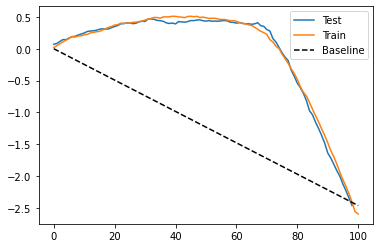

In [12]:
gain_curve_test = cumulative_gain(test.assign(cate=cate_test_transf_y),
                                "cate", y="sales", t="price")

gain_curve_train = cumulative_gain(train.assign(cate=cate_learner.predict(train[["temp", "weekday", "cost"]])),
                                   "cate", y="sales", t="price")


plt.plot(gain_curve_test, label="Test")
plt.plot(gain_curve_train, label="Train")
plt.plot([0, 100], [0, elast(test, "sales", "price")], linestyle="--", color="black", label="Baseline")
plt.legend();

For this data, it looks like the model with transformed target is way better than random. Not only that, train and test results are pretty close, so variance is not an issue here. But this is just a characteristic of this dataset. If you recall, this was not the case when we explored the binary treatment case. There, the model performed not so great. 
 
### Non Linear Treatment Effects
 
Having talked about the continuous case, there is still an elephant in the room we need to adress. We've assumed a linearity on the treatment effect. However, that is very rarely a reasonable assumption. Usually, treatment effects saturate in one form or another. In our example, it's reasonable to think that demand will go down faster at the first units of price increase, but then it will fall slowlier.
 
![img](./data/img/plug-and-play-estimators/non-linear-case.png)
 
The problem here is that **elasticity or treatment effect changes with the treatment itself**. In our example, the treatment effect is more intense at the beginning of the curve and smaller as prices get higher. Again,suppose you have two types of days: hot days (yellow) and cold days (blue) and we want to distinguish between the two with a causal model. The thing is that causal models should predict elasticity, but in the nonlinear case, the elasticity for hot and cold days could be the same, if we look at different price points in the curve (right image).
 
There is no easy way out of this problem and I confess I'm still investigating what works best. For now, the thing that I do is try to think about the functional form of the treatment effect and somehow linearize it. For example, demand usually has the following functional form, where higher $\alpha$s means that demand falls faster with each price increase
 
$
D_i = \dfrac{1}{P_i^{\alpha}}
$

So, if I apply the log transformation to both the demand $Y$ and prices $T$, I should get something that is linear.

$
\begin{align}
log(D)_i &= log\bigg(\dfrac{1}{P_i^{\alpha}}\bigg) \\
&= log(1) - log(P_i^{\alpha}) \\
&= log(1) - log(P_i^{\alpha}) \\
&= - \alpha * log(P_i) \\
\end{align}
$
 
Linearization is not so easy to do, as it involves some thinking. But you can also try stuff out and see what works best. Often, things like logs and square roots help.
 
## Key Ideas

We are now moving in the direction of estimating conditional average treatment effects using machine learning models. The biggest challenge when doing so is adapting a predictive model to one that estimates causal effects. Another way of thinking about it is that predictive models focus on estimating the outcome Y as a function of features X and possibly treatment T $Y = M(X, T) $ while causal models need to estimate the partial derivative of this output function on the treatment $ \partial Y = \partial M(X, T) $. This is far from trivial, because while we do observe the outcome Y, we can't observe $\partial Y$, at least not on an individual level. As a consequence, we need to be creative when designing an objective function for our models. 
 
Here, we saw a very simple technique of target transformation. The idea is to combine the original target Y with the treatment T to form a transformed target which is, in expectation, equal to the CATE. With that new target, we can plug any predictive ML model to estimate it and then the model predictions will be CATE estimates. As a side note, besides target transformation, this method also goes by the name of **F-Learner**. 
 
With all that simplicity, there is also a price to pay. The transformed target is a very noisy estimate of the individual treatment effect and that noise will be transferred to the model estimates in the form of variance. This makes target transformation better suited for big data applications, where variance is less of a problem due to sheer sample sizes. Another downside of the target transformation method is that it is only defined for binary or categorical treatments. We did our best to come up with a continuous version of the approach and even ended up with something that seemed to work, but up until now, there is no solid theoretical framework to back it up. 
 
Finally, we've ended with a discussion on non linear treatment effects and the challenges that come with it. Namely, when the treatment effect changes with the treatment itself, we might mistakenly think units have the same treatment response curve because they have the same responsiveness to the treatment, but actually they are just receiving different treatment amounts. 


## References 
 
The things I've written here are mostly stuff from my head. I've learned them through experience. This means that they have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts.
 
Most of this chapter draws from Susan Atheys' and Guido W. Imbens' paper, *Machine Learning Methods for Estimating Heterogeneous Causal Effects*. Some material about target transformation can also be found on Pierre Gutierrez' and Jean-Yves G´erardy's paper, *Causal Inference and Uplift Modeling: A review of the literature*. Note that these papers only cover the binary treatment case. Another review of causal models for CATE estimation that references the F-Learner is *Meta-learners for Estimating Heterogeneous Treatment Effects using Machine Learning*, by K¨unzel et al, 2019. 

 
## Contribute
 
Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).